In [116]:
import pyspark as ps
from pyspark.sql import SparkSession
import random
import pandas as pd
import numpy as np
from pyspark.ml.recommendation import ALS
from sklearn.metrics import mean_squared_error
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

In [117]:
spark = SparkSession.builder.getOrCreate()

Load pandas dataframes

In [118]:
ratings_df = pd.read_csv('../data/movies/ratings.csv')
movies_df = pd.read_csv('../data/movies/movies.csv')
links_df = pd.read_csv('../data/movies/links.csv')

In [119]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Load spark dataframes

In [120]:
spark_df = spark.createDataFrame(ratings_df)

In [121]:
spark_df.printSchema()

root
 |-- userId: long (nullable = true)
 |-- movieId: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)



Train Test Split on Ratings Spark DataFrame

In [122]:
train, test = spark_df.randomSplit([0.8, 0.2], seed=427471138)

In [123]:
train.registerTempTable('train_ratings')

What is the density of our ratings (utility) matrix?

In [124]:
density = spark.sql("SELECT COUNT(rating)/(COUNT(DISTINCT(movieId))*COUNT(DISTINCT(userId))) AS train_density FROM train_ratings")

In [125]:
density.show()

+--------------------+
|       train_density|
+--------------------+
|0.014229143803102185|
+--------------------+



Average rating might be useful in the future

In [126]:
avg_rating = spark.sql("SELECT AVG(rating) FROM train_ratings")

In [127]:
avg_rating = avg_rating.toPandas()
# avg_rating[avg_rating.index == 0]

In [128]:
avg_rating = avg_rating['avg(rating)'][0]

Create and fit the ALS model

In [208]:
als = ALS(rank=2, maxIter=10, regParam=0.01, alpha=0.1, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")


In [209]:
recommender = als.fit(train)

In [210]:
train_df = train.toPandas()

Predict movie ratings for the Test Data

In [211]:
test_predictions_pd = recommender.transform(test).toPandas()
test_predictions = recommender.transform(test)

Fill N/A values with average rating from Train Data

In [212]:
test_predictions_pd = test_predictions_pd.fillna(train_df['rating'].mean())

In [213]:
test_predictions_pd['squared_error'] = (test_predictions_pd['rating'] - test_predictions_pd['prediction'])**2

RMSE calculation

In [216]:
np.sqrt(mean_squared_error(test_predictions_pd['rating'], test_predictions_pd['prediction']))

0.9749727201255531

In [214]:
# Calculate RMSE
np.sqrt(sum(test_predictions_pd['squared_error']) / len(test_predictions_pd))

0.9749727201255358

(array([4.000e+00, 9.000e+00, 3.200e+01, 8.500e+01, 3.260e+02, 1.049e+03,
        3.655e+03, 9.095e+03, 4.914e+03, 1.050e+02]),
 array([-19.82339979, -17.3529514 , -14.88250301, -12.41205462,
         -9.94160623,  -7.47115784,  -5.00070945,  -2.53026106,
         -0.05981268,   2.41063571,   4.8810841 ]),
 <a list of 10 Patch objects>)

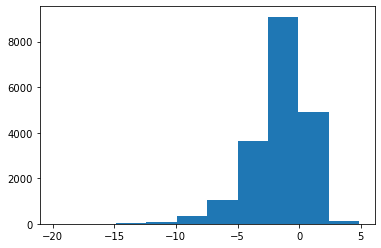

In [136]:
plt.hist(np.log(test_predictions_pd.squared_error))

In [31]:
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

In [33]:
rmse_test

1.1304923742951785

In [38]:
test_recommender.show()

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   575|    148|   4.0|1012605106|       NaN|
|   452|    463|   2.0| 976424451| 2.3215969|
|   602|    471|   3.0| 842357922|  3.836279|
|   440|    471|   3.0| 835337519| 4.5161905|
|   292|    471|   3.5|1140049920| 4.2615166|
|   607|    471|   4.0|1118247731|  3.608962|
|   502|    471|   4.0| 861322541| 4.4119143|
|   585|    471|   4.0| 975363578|  4.261213|
|   509|    471|   4.0| 939329728| 4.2695875|
|   195|    471|   3.0| 976289176| 2.9596322|
|   529|    471|   4.0| 965497394|  3.226784|
|    30|    471|   4.0| 945112993| 3.2388525|
|   547|    496|   3.0| 974778561| 1.0278525|
|   372|   1088|   4.0| 958004568|  4.617034|
|   531|   1088|   5.0|1244288293| 1.1556727|
|   564|   1088|   2.0| 974844186| 1.5185416|
|   505|   1088|   4.0|1340407488|   2.92609|
|   187|   1088|   4.0|1241388285| 3.9068694|
|   597|   1238|   4.0| 940708124|

In [65]:
als1 = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")

recommender1 = als1.fit(train)
train_predictions1 = recommender1.transform(train)

In [59]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")



In [66]:
rmse = evaluator.evaluate(train_predictions1)

In [67]:
rmse

0.528922936096295

In [69]:
!pip install scikit-surprise==1.0.1

     |████████████████████████████████| 1.6MB 1.4MB/s eta 0:00:01
  Created wheel for scikit-surprise: filename=scikit_surprise-1.0.1-cp37-cp37m-linux_x86_64.whl size=1643211 sha256=625497dab77bccf343165dc09a994f9e0ae090da23690bcc479010b322dd1c64
  Stored in directory: /home/jovyan/.cache/pip/wheels/59/18/81/6541505f31aa5b75d142dd840431c6bb4c1461bfb949a44b6e
Successfully built scikit-surprise


In [89]:
import sys
import numpy as np
from surprise import AlgoBase, Dataset, evaluate, Reader

class GlobalMean(AlgoBase):
    def train(self, trainset):

        # Here again: call base method before doing anything.
        AlgoBase.train(self, trainset)

        # Compute the average rating
        self.the_mean = np.mean([r for (_, _, r) in self.trainset.all_ratings()])

    def estimate(self, u, i):

        return self.the_mean


class MeanofMeans(AlgoBase):
    def train(self, trainset):

        # Here again: call base method before doing anything.
        AlgoBase.train(self, trainset)

        users = np.array([u for (u, _, _) in self.trainset.all_ratings()])
        items = np.array([i for (_, i, _) in self.trainset.all_ratings()])
        ratings = np.array([r for (_, _, r) in self.trainset.all_ratings()])

        user_means,item_means = {},{}
        for user in np.unique(users):
            user_means[user] = ratings[users==user].mean()
        for item in np.unique(items):
            item_means[item] = ratings[items==item].mean()

        self.global_mean = ratings.mean()    
        self.user_means = user_means
        self.item_means = item_means
                            
    def estimate(self, u, i):
        """
        return the mean of means estimate
        """
        
        if u not in self.user_means:
            return(np.mean([self.global_mean,
                            self.item_means[i]]))

        if i not in self.item_means:
            return(np.mean([self.global_mean,
                            self.user_means[u]]))

        return(np.mean([self.global_mean,
                        self.user_means[u],
                        self.item_means[i]]))

In [71]:
data = Dataset.load_builtin('ml-100k')

Dataset ml-100k could not be found. Do you want to download it? [Y/n] 

 y


Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /home/jovyan/.surprise_data/ml-100k


In [105]:
Reader(name=None, line_format=u'user item rating timestamp', sep=',', rating_scale=(1, 5), skip_lines=0)

In [106]:
Dataset.load_from_file('../data/movies/ratings.csv', reader)

ValueError: Impossible to parse line. Check the line_format  and sep parameters.

In [101]:
for (uid, iid, rating) in data:
    print(data)

TypeError: 'DatasetAutoFolds' object is not iterable